In [2]:
from functools import partial

import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

## The dataset

We'll use two moons to keep things simple.

(-2.0, 2.0)

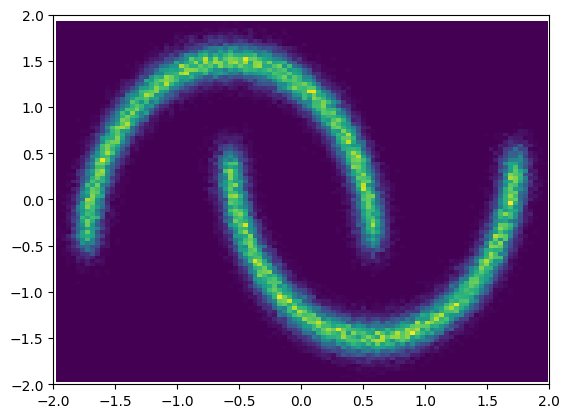

In [6]:
n_samples = 100_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [7]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is the score function.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

Data-corruption is modeled by a variance-preserving SDE:
$$\mathrm dx(t) = -\frac{1}{2}\beta(t)x(t)\mathrm dt + \sqrt{\beta(t)}\mathrm d w(t)$$
for $t\in[0, 1]$. The mean and variance of this VP-SDE are given in terms of the integral of beta (`int_beta` here); see Eq. (29) of [Song et al (2020)](https://arxiv.org/abs/2011.13456) for details.

In [30]:
@partial(jax.jit, static_argnums=(4,))
def loss_fn(params, x, t1, t2, score, key):

    eps = 2e-3

    z = jax.random.normal(key, shape=x.shape)

    x2 = x + z * t2
    x2 = score.apply(params, np.concatenate([x2, t2], -1))

    t2 = t2 - eps
    c_skip_t = 0.25 / (t2 ** 2 + 0.25)
    c_out_t = 0.25 * t2 / np.sqrt((t2 + eps) ** 2 + 0.25)

    x2 = x * c_skip_t + x2 * c_out_t

    x1 = x + z * t1
    return np.mean((x1 - x2) ** 2) 

In [31]:
import math

n_epoch = 10
epoch = 0

N = math.ceil(math.sqrt((epoch * (150**2 - 4) / n_epoch) + 4) - 1) + 1
N

2

In [32]:
def kerras_boundaries(sigma, eps, N, T):
    # This will be used to generate the boundaries for the time discretization

    return np.array([
            (eps ** (1 / sigma) + i / (N - 1) * (T ** (1 / sigma) - eps ** (1 / sigma)))
            ** sigma
            for i in range(N)
            ])
    
N = 100
boundaries = kerras_boundaries(7.0, 0.002, N, 80.0)



In [33]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

score = MLP(hidden_dim=128, out_dim=2, n_layers=5)
params = score.init(key, np.concatenate([x, t], axis=1))

loss_fn(params, x, t, t, score, key)

Array(1.6264122, dtype=float32)

In [579]:
opt = optax.adamw(learning_rate=3e-4, weight_decay=1e-4)
opt_state = opt.init(params)

In [580]:
n_steps = 10_000
n_batch = 128
T = 1.

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        t_batch = jax.random.uniform(key, shape=(x_batch.shape[0], 1), minval=0., maxval=T)

        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_batch, int_beta, score, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 10000/10000 [04:01<00:00, 41.49it/s, val=3.9526124]
